In [1]:
!pip install transformers

In [ ]:
import sqlite3

# Path to your SQLite database
db_path = '/data/food_allergy.db'
# Connect to the SQLite database
connection = sqlite3.connect(db_path)
cursor = connection.cursor()

In [2]:
def list_tables(cursor):
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    return [t[0] for t in cursor.fetchall()]

In [3]:
tables = list_tables(cursor)

In [21]:
tables

['EmergencySymptoms',
 'sqlite_sequence',
 'Precautions',
 'PreventionTips',
 'AllergyTestDetails',
 'Treatments',
 'FoodData',
 'FoodAllergies',
 'ProductRecalls']

In [4]:
def fetch_data(table_name):
    cursor.execute(f"SELECT * FROM {table_name};")
    return cursor.fetchall()

# Extract data from each table
table_data = {table: fetch_data(table) for table in tables}

In [5]:
labels = [1] * len(table_data['EmergencySymptoms'])

In [8]:
labels

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [6]:
from transformers import DistilBertTokenizer 
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Function to preprocess textual data
def preprocess_text(data):
    tokenized = []
    for description in data:
        if description:
            tokens = tokenizer(description[0].lower().strip(), truncation=True, padding='max_length', max_length=512, return_tensors="pt")
            tokenized.append(tokens)
    return tokenized

# Preprocess descriptions from EmergencySymptoms
preprocessed_data = preprocess_text([item[1] for item in table_data['EmergencySymptoms']])  # assuming item[1] is the description

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# Assuming all entries have the same length
input_ids = torch.cat([entry['input_ids'] for entry in preprocessed_data], dim=0)
attention_mask = torch.cat([entry['attention_mask'] for entry in preprocessed_data], dim=0)

# Create the dataset
dataset = CustomDataset({'input_ids': input_ids, 'attention_mask': attention_mask}, labels)


In [8]:
from torch.utils.data import random_split
total_size = len(dataset)
val_size = int(0.2 * total_size)  # 20% for validation
train_size = total_size - val_size

train_dataset, validation_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)

In [9]:
from transformers import DistilBertForSequenceClassification, AdamW

# Load the pre-trained DistilBERT model for sequence classification
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',  # Base model
    num_labels=2,               # Number of output labels (e.g., binary classification)
    output_attentions=False,    # Whether the model returns attentions weights.
    output_hidden_states=False  # Whether the model returns all hidden-states.
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [10]:
from torch.utils.data import DataLoader

In [11]:
# Setup the optimizer
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

from transformers import get_linear_schedule_with_warmup
num_epochs = 10
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0,
    num_training_steps=len(train_loader) * num_epochs
)

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Function to compute accuracy
def compute_accuracy(predictions, labels):
    return accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())

# Lists to store metrics for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Initialize lists for storing logits for validation
all_val_logits = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    all_predictions = []
    all_labels = []
    
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch['labels']
        
        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        
        all_predictions.extend(predictions.detach())
        all_labels.extend(labels.detach())
    
    train_accuracy = compute_accuracy(torch.stack(all_predictions), torch.stack(all_labels))
    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    total_val_loss = 0
    all_val_predictions = []
    all_val_labels = []
    for batch in validation_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch['labels']
        
        with torch.no_grad():
            outputs = model(**batch)
        
        val_loss = outputs.loss
        total_val_loss += val_loss.item()
        val_logits = outputs.logits
        val_predictions = torch.argmax(val_logits, dim=-1)
        
        all_val_logits.append(val_logits)  # Store logits for further analysis
        all_val_predictions.extend(val_predictions.detach())
        all_val_labels.extend(labels.detach())
    
    val_accuracy = compute_accuracy(torch.stack(all_val_predictions), torch.stack(all_val_labels))
    val_losses.append(total_val_loss / len(validation_loader))
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Flatten all validation logits for further metric calculations
all_val_logits = torch.cat(all_val_logits, dim=0)

/tmp/ipykernel_33/675739271.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_33/675739271.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 1/10, Train Loss: 0.0811, Train Accuracy: 1.0000, Val Loss: 0.0655, Val Accuracy: 1.0000


/tmp/ipykernel_33/675739271.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_33/675739271.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 2/10, Train Loss: 0.0711, Train Accuracy: 1.0000, Val Loss: 0.0655, Val Accuracy: 1.0000


/tmp/ipykernel_33/675739271.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_33/675739271.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 3/10, Train Loss: 0.0725, Train Accuracy: 1.0000, Val Loss: 0.0655, Val Accuracy: 1.0000


/tmp/ipykernel_33/675739271.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_33/675739271.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 4/10, Train Loss: 0.0818, Train Accuracy: 1.0000, Val Loss: 0.0655, Val Accuracy: 1.0000


/tmp/ipykernel_33/675739271.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_33/675739271.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 5/10, Train Loss: 0.0751, Train Accuracy: 1.0000, Val Loss: 0.0655, Val Accuracy: 1.0000


/tmp/ipykernel_33/675739271.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_33/675739271.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 6/10, Train Loss: 0.0737, Train Accuracy: 1.0000, Val Loss: 0.0655, Val Accuracy: 1.0000


/tmp/ipykernel_33/675739271.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_33/675739271.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 7/10, Train Loss: 0.0688, Train Accuracy: 1.0000, Val Loss: 0.0655, Val Accuracy: 1.0000


/tmp/ipykernel_33/675739271.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_33/675739271.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 8/10, Train Loss: 0.0763, Train Accuracy: 1.0000, Val Loss: 0.0655, Val Accuracy: 1.0000


/tmp/ipykernel_33/675739271.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_33/675739271.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 9/10, Train Loss: 0.0731, Train Accuracy: 1.0000, Val Loss: 0.0655, Val Accuracy: 1.0000


/tmp/ipykernel_33/675739271.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_33/675739271.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 10/10, Train Loss: 0.0738, Train Accuracy: 1.0000, Val Loss: 0.0655, Val Accuracy: 1.0000


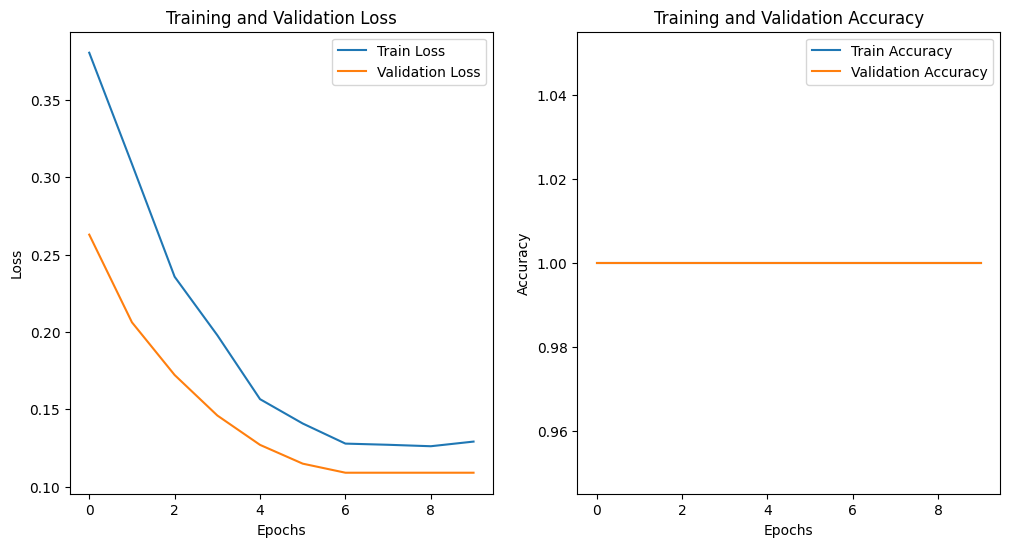

In [22]:
# Plotting training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# Save the model weights
torch.save(model.state_dict(), 'model_weights.pth')

# Optionally, save the entire model
torch.save(model, 'entire_model.pth')
